In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from collections import defaultdict

# 데이터 불러오기

In [77]:
df = pd.read_csv('./dataset/must_use_final.csv')  
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = df.sort_values("TIMESTAMP").reset_index(drop=True)
# 시점 정렬해서 5시간 시점만 추출하기 위해서

## 시점 추출

In [81]:
max_gap = pd.Timedelta(minutes=10) # 타겟 시점과 실제 데이터 시간의 최대 허용 오차를 10분으로 제한함
time_offsets = [17]  # 선박별로 출항 시점 기준으로 3,5,9 시간 뒤의 위치 데이터를 추출 -> 여기 수정해서 사용 ✅
time_based_data = {hour: [] for hour in time_offsets}  # 각 시간마다 추출된 데이터를 담을 빈 리스트로 시작함

for (vsl_id, port), group in df.groupby(["VSL_ID", "PORT_NAME"]): # 선박과 도착항구의 조합별로 데이터 나눠서 봄
    group = group.sort_values("TIMESTAMP")   # 해당 선박의 데이터를 시간순 정렬
    if group.empty:   # 비어있으면 contimue로 패스
        continue
    start_time = group["TIMESTAMP"].min()   # 출발 시점을 start time 설정
    for hour in time_offsets:
        target_time = start_time + pd.Timedelta(hours=hour)
        time_diff = (group["TIMESTAMP"] - target_time).abs()  # .abs() 절대값
        closest_idx = time_diff.idxmin()    # idxmin(): 가장 작은 차이를 가진 인덱스 추출
        if time_diff[closest_idx] <= max_gap: # max_gap 10 분 보다 시간 차이 크면 무시
            closest_row = group.loc[closest_idx]    # 조건 통과시 row 뽑아서 저장
            time_based_data[hour].append(closest_row) # time_based_data[hour] 여기에 추가
df_5h = pd.DataFrame(time_based_data[17]).reset_index(drop=True)  # 5시간 뒤 시의 데이터만 모음

# 학습 / 테스트 데이터 분리

In [83]:
feature_cols = ['LAT', 'LON', 'COG', 'HEADING']  # 독립 변수
target_col = 'CLUSTER_1'     # 종속변수
X = df_5h[feature_cols].values   # 값만 뽑아내기
y = df_5h[target_col].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42       # stratify=y : 클래스 비율 유지하면서 train/test 분할
)  

# 각 모델 별 하이퍼 파라미터 튜닝 + 앙상블 구성

In [85]:
# ===== RandomForest 하이퍼파라미터 튜닝 =====
param_grid_rf = {      # 여기서 정의한 값들을 조합해 최적 성능을 내는 조합을 찾는 과정
    'n_estimators': [100, 200],   # 트리 몇 개 만들지 (많을수록 성능 안정)
    'max_depth': [8, 10],       # 각 트리의 최대 깊이 (적절한 깊이가 중요)
    'min_samples_split': [2, 5],   # 노드 분할하기 위해 필요한 최소 샘플 수
    'max_features': ['sqrt', 'log2']   # 각 트리 노드를 분할할 때 몇 개 특성을 고려할지 / 'sqrt': 전체 특성 수의 제곱근 / 'log2': 전체 특성 수의 로그2
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("✅ 최적 RF 파라미터:", grid_rf.best_params_)

# ===== XGBoost 하이퍼파라미터 튜닝 =====
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("✅ 최적 XGB 파라미터:", grid_xgb.best_params_)

# ===== KNN 하이퍼파라미터 튜닝 =====
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_
print("✅ 최적 KNN 파라미터:", grid_knn.best_params_)

# ===== 최적 모델로 소프트 보팅 앙상블 구성 =====
classifier = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('knn', best_knn),
    ('xgb', best_xgb)
], voting='soft')
classifier.fit(X_train, y_train)

✅ 최적 RF 파라미터: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
✅ 최적 XGB 파라미터: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
✅ 최적 KNN 파라미터: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     random_state=42)),
                             ('knn', KNeighborsClassifier(p=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_me...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

# 예측 및 정확도 출력

In [87]:
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 전체 모델 정확도: {accuracy:.4f}")


🎯 전체 모델 정확도: 0.8571


# 혼동 행렬 시각화

<Figure size 1000x800 with 0 Axes>

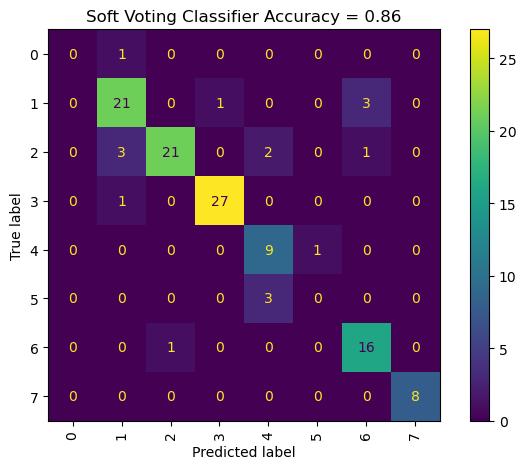

In [89]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90)
plt.title(f"Soft Voting Classifier Accuracy = {accuracy:.2f}")
plt.tight_layout()
plt.show()

# 클래스별 정확도 계산

In [91]:
class_accuracy = defaultdict(list)
for true_label, pred_label in zip(y_test, y_pred):
    class_accuracy[true_label].append(true_label == pred_label)

print("\n📌 클래스별 정확도 (CLUSTER_1 오름차순):")
for cls in sorted(class_accuracy.keys()):
    acc = np.mean(class_accuracy[cls])
    print(f" - {cls}: {acc:.4f}")


📌 클래스별 정확도 (CLUSTER_1 오름차순):
 - 0: 0.0000
 - 1: 0.8400
 - 2: 0.7778
 - 3: 0.9643
 - 4: 0.9000
 - 5: 0.0000
 - 6: 0.9412
 - 7: 1.0000


# 정밀도, 재현율, F1-score, 교차검증 + macro F1-score 평가

In [93]:
# ===== 정밀도, 재현율, F1-score 출력 =====
print("\n📊 분류 성능 보고서 (classification report):")
print(classification_report(y_test, y_pred, digits=4))

# ===== 교차검증 + macro F1-score 평가 =====
print("\n🔁 [교차검증] 5-Fold 예측 수행 중...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(classifier, X, y, cv=skf)
acc_cv = accuracy_score(y, y_pred_cv)
macro_f1 = f1_score(y, y_pred_cv, average='macro')
weighted_f1 = f1_score(y, y_pred_cv, average='weighted')

print(f"\n✅ [교차검증] 전체 정확도: {acc_cv:.4f}")
print(f"🌍 [교차검증] macro F1-score: {macro_f1:.4f}")
print(f"⚖️ [교차검증] weighted F1-score: {weighted_f1:.4f}\n")

print("📊 [교차검증] classification report:")
print(classification_report(y, y_pred_cv, digits=4))

print("\n📌 [교차검증] CLUSTER_1별 정확도:")
class_accuracy_cv = defaultdict(list)
for true_label, pred_label in zip(y, y_pred_cv):
    class_accuracy_cv[true_label].append(true_label == pred_label)

for cls in sorted(class_accuracy_cv):
    acc = np.mean(class_accuracy_cv[cls])
    print(f" - CLUSTER_1 = {cls}: 정확도 {acc:.4f} ({len(class_accuracy_cv[cls])}개 샘플)")


📊 분류 성능 보고서 (classification report):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         1
           1     0.8077    0.8400    0.8235        25
           2     0.9545    0.7778    0.8571        27
           3     0.9643    0.9643    0.9643        28
           4     0.6429    0.9000    0.7500        10
           5     0.0000    0.0000    0.0000         3
           6     0.8000    0.9412    0.8649        17
           7     1.0000    1.0000    1.0000         8

    accuracy                         0.8571       119
   macro avg     0.6462    0.6779    0.6575       119
weighted avg     0.8487    0.8571    0.8482       119


🔁 [교차검증] 5-Fold 예측 수행 중...

✅ [교차검증] 전체 정확도: 0.8655
🌍 [교차검증] macro F1-score: 0.7551
⚖️ [교차검증] weighted F1-score: 0.8596

📊 [교차검증] classification report:
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         4
           1     0.8295    0.8795    0.8538     

In [95]:
import joblib
import os

# 모델 저장
joblib.dump(classifier, 'model/cluster_17hours.joblib')

# 인코더 저장
# joblib.dump(le, 'model/encoder_2.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


In [8]:
import pandas as pd
from IPython.display import display

# 파일 불러오기
df = pd.read_csv('./dataset/must_use_final.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

# 항구 코드 입력 받기
selected_port = 'KRKPO' # 원하는 항구 코드로 변경 가능

# 해당 항구로 향하는 데이터 필터링
filtered = df[df['PORT_CD'] == selected_port].copy()

# 선박별 출발/도착 시각 추출
grouped = filtered.groupby('VSL_ID').agg(
    start_time=('TIMESTAMP', 'min'),
    end_time=('TIMESTAMP', 'max')
)

# 소요 시간 계산 및 포맷팅
grouped['duration_hours'] = ((grouped['end_time'] - grouped['start_time']).dt.total_seconds() / 3600)
grouped['소요 시간'] = grouped['duration_hours'].apply(lambda x: f"{x:.2f} 시간")

# 최종 결과 DataFrame 구성
final_df = grouped.reset_index()[['VSL_ID', 'start_time', 'end_time', '소요 시간']]

# 결과 출력
display(final_df)


,VSL_ID,start_time,end_time,소요 시간
0,066f57f1-275e-3df0-880b-f550d6439fa0,2024-07-05 10:40:00,2024-07-05 17:40:00,7.00 시간
1,0b3624b7-f774-30cb-badd-0f88e46a0a17,2024-11-12 00:30:00,2024-11-12 10:00:00,9.50 시간
2,0e7e0218-1a1c-3084-86fa-9073caa48b63,2024-08-30 06:30:00,2024-08-30 14:40:00,8.17 시간
3,0f1d4375-f87c-3fdd-97ba-b6d75b091a7f,2024-10-30 19:00:00,2024-10-31 02:10:00,7.17 시간
4,143b2ceb-66cd-3563-aae1-c7abb78dc998,2024-12-12 17:30:00,2024-12-13 00:30:00,7.00 시간
5,2019bfe5-f4aa-3b49-a05c-8589fd94a0bd,2024-11-22 09:50:00,2024-11-24 04:40:00,42.83 시간
6,4c175652-64b2-3446-a98c-c6eb8c985f5a,2024-08-31 14:40:00,2024-08-31 23:10:00,8.50 시간
7,5656435b-e527-3612-8849-f4d2a1d82db3,2024-10-14 07:10:00,2024-10-14 17:40:00,10.50 시간
8,56670d2d-3cfc-3153-9407-00179f909c11,2024-07-28 11:40:00,2024-07-28 18:30:00,6.83 시간
9,591569db-279d-3dbe-bdfb-bf0f18bb7d1a,2024-11-03 04:30:00,2024-11-03 12:40:00,8.17 시간
